# 1) Dataset Exploration

In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.interpolate import UnivariateSpline

color = sns.color_palette()

%matplotlib inline

In [5]:
path = "iowa_data.csv"

In [6]:
# read csv
data = pd.read_csv(path)

In [7]:
data.columns

Index([u'Fiscal Year', u'Department', u'Agency/Institution', u'Name',
       u'Gender', u'Place of Residence', u'Position',
       u'Base Salary Payment Method', u'Base Salary Payment Amount',
       u'Base Salary Date', u'Total Salary Paid', u'Travel & Subsistence'],
      dtype='object')

In [8]:
data.shape

(665325, 12)

In [9]:
data.head()

,Fiscal Year,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary Payment Method,Base Salary Payment Amount,Base Salary Date,Total Salary Paid,Travel & Subsistence
0,2007-01-01,"Administrative Services, Department of",NaN,ABELS BEVERLY J,F,POLK,ADVANCED PERSONNEL MGMT,HR,31.62,2007-07-01,6462.34,NaN
1,2007-01-01,"Administrative Services, Department of",NaN,ABRAMS JERRY A,M,WAPELLO,EARLY OUT POSITION,TERMINATED,NaN,2007-07-01,4242.82,NaN
2,2007-01-01,"Administrative Services, Department of",NaN,ADAMS CAROL L,F,MITCHELL,ADVANCED PERSONNEL MGMT,BW,2212.80,2007-07-01,55065.60,924.44
3,2007-01-01,"Administrative Services, Department of",NaN,ADAMS JEANNIE R,F,POLK,ACCOUNTING TECHNICIAN 2,BW,1226.40,2007-07-01,30800.83,6.80
4,2007-01-01,"Administrative Services, Department of",NaN,ADAMS NED J,M,POLK,EARLY OUT POSITION,TERMINATED,NaN,2007-07-01,10634.33,NaN


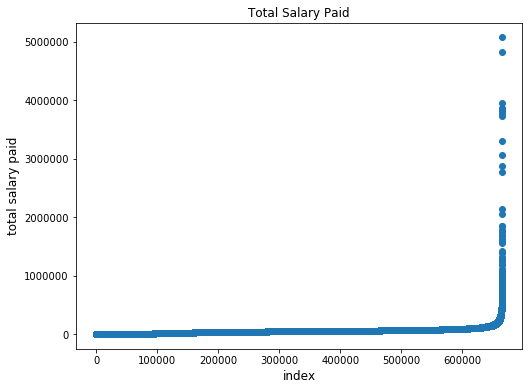

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(range(data.shape[0]), np.sort(data["Total Salary Paid"].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('total salary paid', fontsize=12)
plt.title("Total Salary Paid")
plt.show()

In [11]:
data["Base Salary Date"].unique()

array(['2007-07-01', '2008-07-01', '2009-07-01', '2010-07-01',
       '2011-07-01', '2012-07-01', '2013-07-01', '2014-07-01',
       '2015-07-01', '2016-07-01', '2017-07-01'], dtype=object)

Everyone starts in July

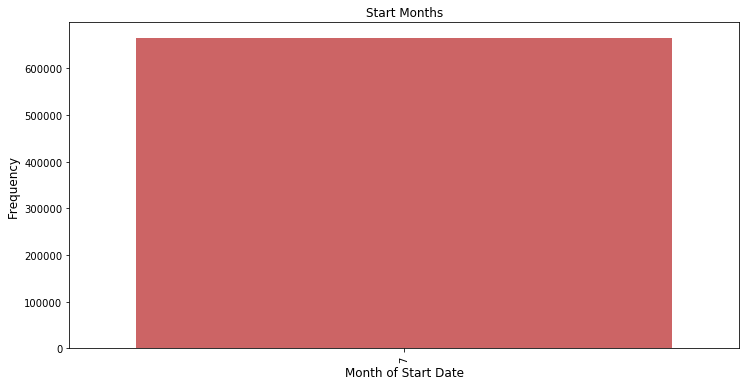

In [12]:
data["Base Salary Date"] = pd.to_datetime(data["Base Salary Date"], errors="coerce")
data["Start Month"] =  data["Base Salary Date"].dt.month
cnt_srs = data["Start Month"].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of Start Date', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title("Start Months")
plt.show()

Most names/people only appear 1 in the dataset, only 1 person appeared 32 times

In [13]:
data["Name"].value_counts().head()

JONES JULIE A           32
OLSON SUSAN M           30
TAYLOR RICHARD D        25
WILLIAMS JOHN W         24
KATES,KENNETH PHILIP    24
Name: Name, dtype: int64

In [14]:
(data["Name"].value_counts().reset_index())['Name'].value_counts()

1     72774
2     25917
10    13737
3     13488
11    10468
4      9716
9      7136
5      6662
6      5337
7      4702
8      4385
12      649
13      129
14       32
15       17
16       10
20       10
17        9
19        9
21        6
18        4
22        3
24        3
23        2
30        1
25        1
32        1
Name: Name, dtype: int64

Oddly enough less people started working after 2007, what could have happened?

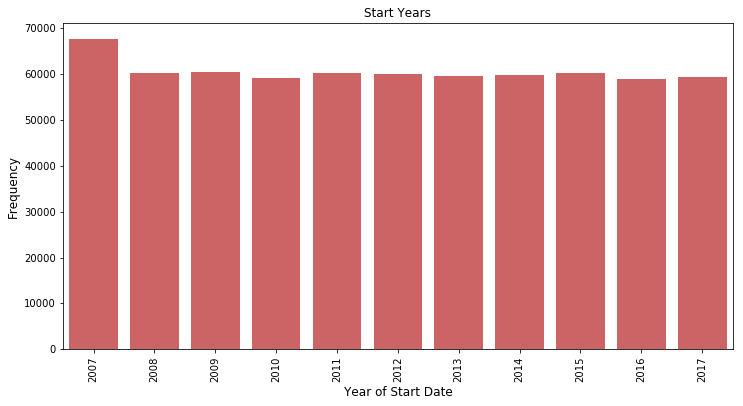

In [15]:
data["Start Year"] =  data["Base Salary Date"].dt.year
cnt_srs = data["Start Year"].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Year of Start Date', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title("Start Years")
plt.show()

Which columns are missing the most data?

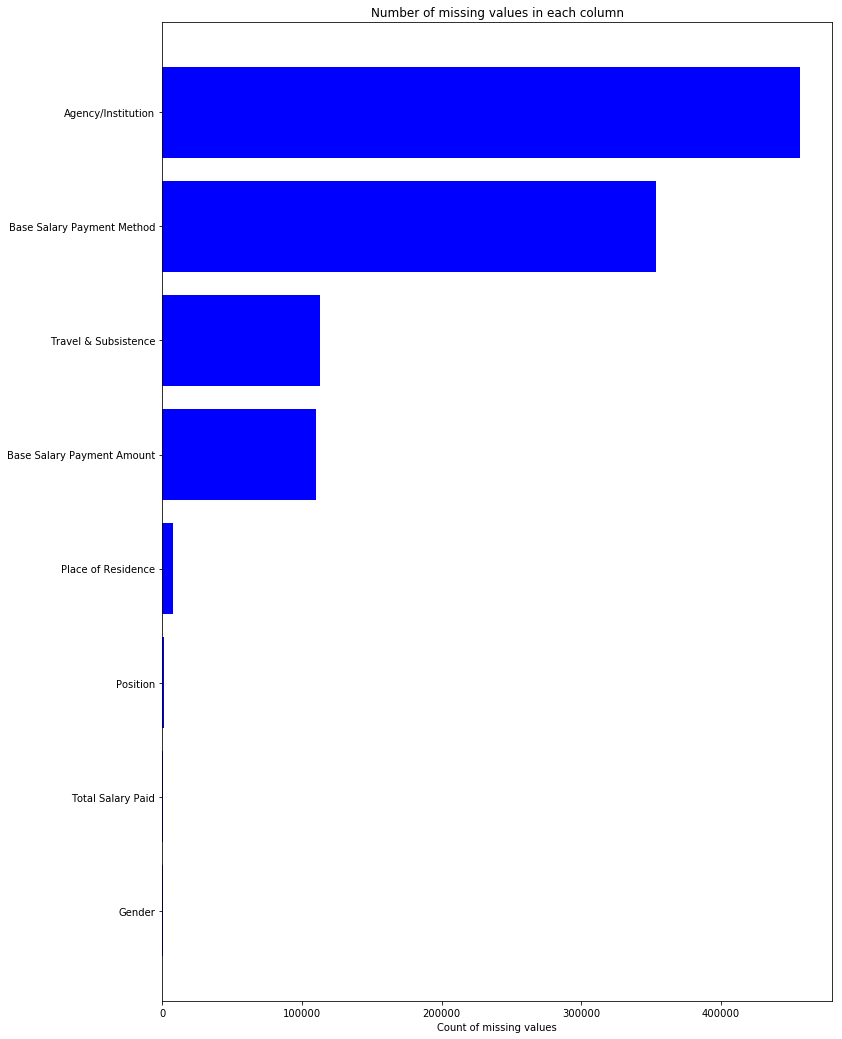

In [16]:
missing_df = data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [17]:
missing_df

,column_name,missing_count
4,Gender,270
10,Total Salary Paid,635
6,Position,1418
5,Place of Residence,7425
8,Base Salary Payment Amount,110124
11,Travel & Subsistence,113190
7,Base Salary Payment Method,353712
2,Agency/Institution,456930


In [18]:
dtype_df = data.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,Fiscal Year,object
1,Department,object
2,Agency/Institution,object
3,Name,object
4,Gender,object
5,Place of Residence,object
6,Position,object
7,Base Salary Payment Method,object
8,Base Salary Payment Amount,float64
9,Base Salary Date,datetime64[ns]


All the tax years start in January

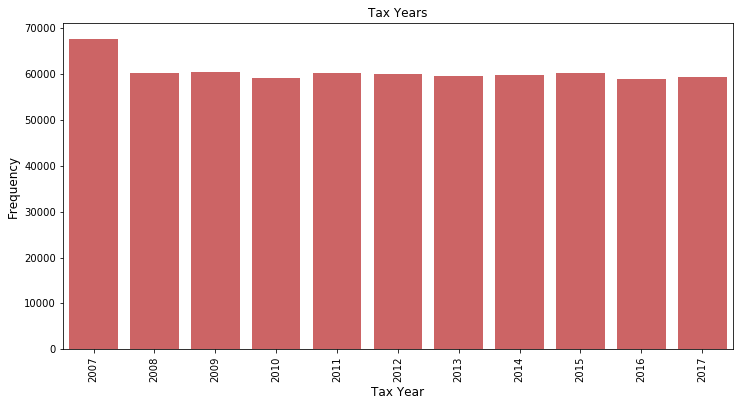

In [19]:
data["Fiscal Year"] = pd.to_datetime(data["Fiscal Year"], errors="coerce")
data["Tax Year"] =  data["Fiscal Year"].dt.year
cnt_srs = data["Tax Year"].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Tax Year', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title("Tax Years")
plt.show()

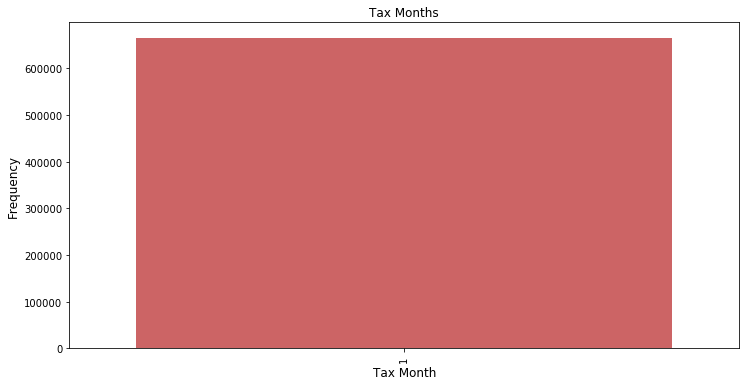

In [20]:
data["Tax Month"] =  data["Fiscal Year"].dt.month
cnt_srs = data["Tax Month"].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Tax Month', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title("Tax Months")
plt.show()

Conclusion: the tax year and salary year can be combined into one column

The other gender types are insignificant compared to the main gender types, will probably drop them from the analysis

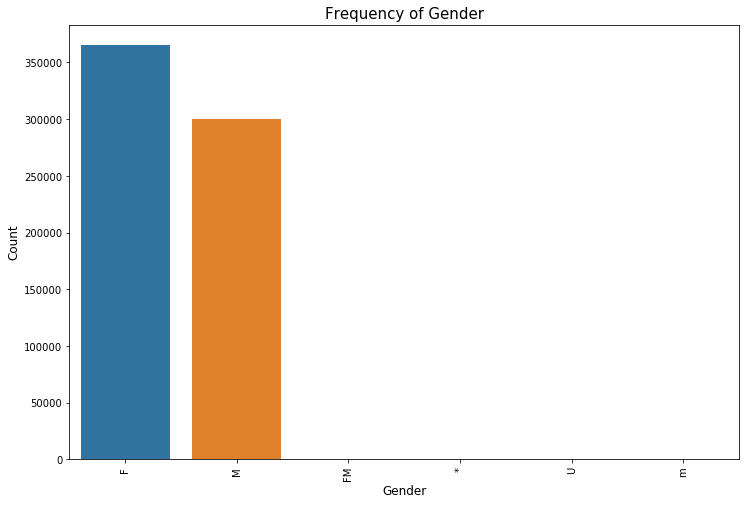

In [21]:
plt.figure(figsize=(12,8))
sns.countplot(x="Gender", data=data)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Gender", fontsize=15)
plt.show()

In [22]:
data.Gender.value_counts()

F     365135
M     299869
*         44
U          5
FM         1
m          1
Name: Gender, dtype: int64

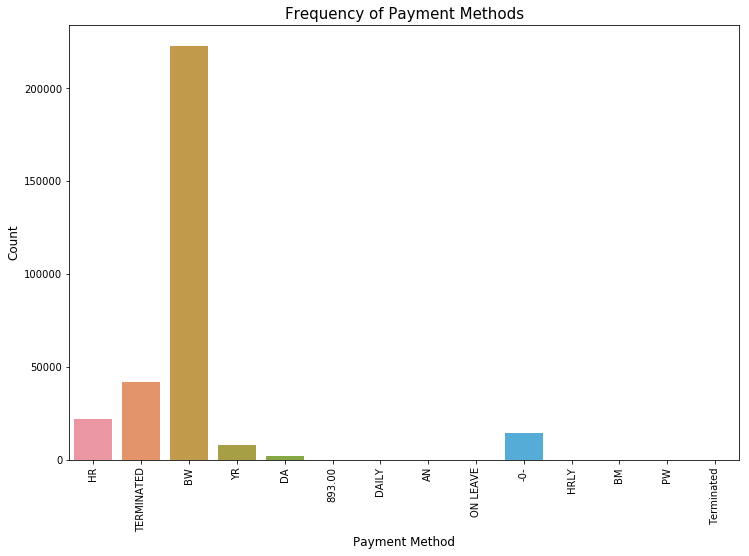

In [23]:
plt.figure(figsize=(12,8))
sns.countplot(x="Base Salary Payment Method", data=data)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Payment Method', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Payment Methods", fontsize=15)
plt.show()

In [24]:
data["Base Salary Payment Method"].value_counts()

BW            222943
TERMINATED     41706
HR             21943
-0-            14655
YR              7834
DA              2190
HRLY             106
AN                86
DAILY             64
ON LEAVE          50
Terminated        32
PW                 2
BM                 1
893.00             1
Name: Base Salary Payment Method, dtype: int64

Change the Terminated to TERMINATED, not documented very well
Can we drop this column and just calculate hourly rate, hours worked?
(As mentioned in chat)

In [25]:
data.loc[data["Base Salary Payment Method"] == "Terminated", "Base Salary Payment Method"] = "TERMINATED"
data["Base Salary Payment Method"].value_counts()

BW            222943
TERMINATED     41738
HR             21943
-0-            14655
YR              7834
DA              2190
HRLY             106
AN                86
DAILY             64
ON LEAVE          50
PW                 2
BM                 1
893.00             1
Name: Base Salary Payment Method, dtype: int64

In [26]:
data["Total Salary Paid"].value_counts().head()

2000.00     435
1600.00     423
39437.84    397
1000.00     373
1500.00     363
Name: Total Salary Paid, dtype: int64

In [27]:
data["Total Salary Paid"].value_counts().tail()

84838.00    1
63413.64    1
56620.76    1
59190.36    1
65833.00    1
Name: Total Salary Paid, dtype: int64

635/665325 0.09 % of the data, we can choose to drop them  

In [28]:
missing_base_sal_df = data.loc[data["Total Salary Paid"].isnull()]

In [29]:
missing_base_sal_df.head(10)

,Fiscal Year,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary Payment Method,Base Salary Payment Amount,Base Salary Date,Total Salary Paid,Travel & Subsistence,Start Month,Start Year,Tax Year,Tax Month
11881,2007-01-01,Iowa State University,NaN,CANNON ANN M,F,STORY,NaN,NaN,2763.98,2007-07-01,NaN,NaN,7,2007,2007,1
14257,2007-01-01,Iowa State University,NaN,ALEKSANDROVA SVETLIN,F,STORY,NaN,NaN,2734.78,2007-07-01,NaN,NaN,7,2007,2007,1
14263,2007-01-01,Iowa State University,NaN,ALEXANDER KATHRINE M,F,STORY,NaN,NaN,18409.20,2007-07-01,NaN,NaN,7,2007,2007,1
14319,2007-01-01,Iowa State University,NaN,ALMONTE ANA M,F,INGHAM,NaN,NaN,1790.71,2007-07-01,NaN,NaN,7,2007,2007,1
14330,2007-01-01,Iowa State University,NaN,ALTENHOFEN LINDSEY M,F,STORY,NaN,NaN,7493.61,2007-07-01,NaN,NaN,7,2007,2007,1
14352,2007-01-01,Iowa State University,NaN,AMOAKO RANDY OSEI,M,STORY,NaN,NaN,1777.72,2007-07-01,NaN,NaN,7,2007,2007,1
14363,2007-01-01,Iowa State University,NaN,ANDERSEN ASHLEY N,F,BROWARD,NaN,NaN,2254.25,2007-07-01,NaN,NaN,7,2007,2007,1
14377,2007-01-01,Iowa State University,NaN,ANDERSON ANTOINETTE,F,HINDS,NaN,NaN,2250.00,2007-07-01,NaN,NaN,7,2007,2007,1
14382,2007-01-01,Iowa State University,NaN,ANDERSON BETH ELLEN,F,STORY,NaN,NaN,3386.11,2007-07-01,NaN,NaN,7,2007,2007,1
14424,2007-01-01,Iowa State University,NaN,ANDERSON KARSTEN L,M,OLMSTED,NaN,NaN,1829.00,2007-07-01,NaN,NaN,7,2007,2007,1


Very similar graph to total salary paid

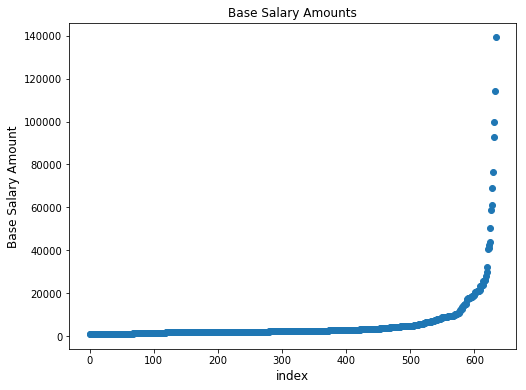

In [30]:
plt.figure(figsize=(8,6))
plt.scatter(range(missing_base_sal_df.shape[0]), np.sort(missing_base_sal_df["Base Salary Payment Amount"].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Base Salary Amount', fontsize=12)
plt.title("Base Salary Amounts")
plt.show()

What if we replace the missing total salary paid with the base salary;
only 1 base salary is missing out of the 635 rows whose total paid salary is null

In [31]:
missing_base_sal_df["Base Salary Payment Amount"].isnull().sum()

1

All of the data have same start year and tax year, combine them into one column

In [32]:
np.sum(data["Start Year"] == data ["Tax Year"])

665325

In [33]:
data.rename(index=str,columns={"Start Year":"Year"},inplace=True)
data.drop(["Fiscal Year", "Base Salary Date", "Start Month", "Tax Year", "Tax Month"],axis=1,inplace=True)

Drop the rows that have nan total salary paid of nan, 665325-635=664690

In [34]:
data.dropna(subset=["Total Salary Paid"], inplace=True)
data.shape

(664690, 11)

In [35]:
data.head()

,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary Payment Method,Base Salary Payment Amount,Total Salary Paid,Travel & Subsistence,Year
0,"Administrative Services, Department of",NaN,ABELS BEVERLY J,F,POLK,ADVANCED PERSONNEL MGMT,HR,31.62,6462.34,NaN,2007
1,"Administrative Services, Department of",NaN,ABRAMS JERRY A,M,WAPELLO,EARLY OUT POSITION,TERMINATED,NaN,4242.82,NaN,2007
2,"Administrative Services, Department of",NaN,ADAMS CAROL L,F,MITCHELL,ADVANCED PERSONNEL MGMT,BW,2212.80,55065.60,924.44,2007
3,"Administrative Services, Department of",NaN,ADAMS JEANNIE R,F,POLK,ACCOUNTING TECHNICIAN 2,BW,1226.40,30800.83,6.80,2007
4,"Administrative Services, Department of",NaN,ADAMS NED J,M,POLK,EARLY OUT POSITION,TERMINATED,NaN,10634.33,NaN,2007


Algo 1

Determine part time/full time using iowa minimum wage

1 year = 8760 hours = 52 weeks

part time = less than 30 hours per week

full time = more than 40 hours per week


Minimum Wage Rates 2007-17

2007 - 5.15

2008-17 - 7.25

Consistency between the two genders

In [36]:
#  if total paid/min wage = hours worked > 40*52 = hours worked a year if full time, consider as full time
# 0 full time
# 1 is part time
def part_full_label(row):
    full = 50*40 # 50 instead of 52, bc min 2 weeks off
    if row["Year"] == 2007:
        if row["Total Salary Paid"]/5.15 > full:
            return 0
        return 1
    
    if row["Total Salary Paid"]/7.25 > full:
        return 0
    return 1
    

Algo 2 (Nick's algo)

In [37]:
def hourly_estimates(x):
    # dictionary containing conversions of method to number of hours
    method_to_hour_estimate = {'HR': 1, 'BW': 80, 'YR': 2000, 'DA': 8, 'DAILY': 8, 
                               'AN': 2000, 'HRLY': 1, 'BM': 333.33, 'PW': 40}
    # get data from row
    method, amount_per_method, total = x["Base Salary Payment Method"], x["Base Salary Payment Amount"], x["Total Salary Paid"]
    # calc hourly wage and hours worked
    try:
        hourly_wage_estimate = amount_per_method / method_to_hour_estimate.get(method, np.nan) # if the dict does not have a conversion the default is NaN
        hours_worked_estimate = total/hourly_wage_estimate
    except ZeroDivisionError:
        hourly_wage_estimate = np.nan
        hours_worked_estimate = np.nan
    # return tuple
    return hourly_wage_estimate, hours_worked_estimate

In [38]:
def part_full_label2(row):    
    if np.isnan(row["Hour's Worked Estimate"]):
        full = 50*40
        if row["Year"] == 2007:
            if row["Total Salary Paid"]/5.15 > full:
                return 0
            return 1

        if row["Total Salary Paid"]/7.25 > full:
            return 0
        return 1
    if row["Hour's Worked Estimate"] > 40:        
        return 0
    return 1    

In [39]:
data["Employment Type"] = data.apply(lambda row: part_full_label(row), axis=1)
data.head()

,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary Payment Method,Base Salary Payment Amount,Total Salary Paid,Travel & Subsistence,Year,Employment Type
0,"Administrative Services, Department of",NaN,ABELS BEVERLY J,F,POLK,ADVANCED PERSONNEL MGMT,HR,31.62,6462.34,NaN,2007,1
1,"Administrative Services, Department of",NaN,ABRAMS JERRY A,M,WAPELLO,EARLY OUT POSITION,TERMINATED,NaN,4242.82,NaN,2007,1
2,"Administrative Services, Department of",NaN,ADAMS CAROL L,F,MITCHELL,ADVANCED PERSONNEL MGMT,BW,2212.80,55065.60,924.44,2007,0
3,"Administrative Services, Department of",NaN,ADAMS JEANNIE R,F,POLK,ACCOUNTING TECHNICIAN 2,BW,1226.40,30800.83,6.80,2007,0
4,"Administrative Services, Department of",NaN,ADAMS NED J,M,POLK,EARLY OUT POSITION,TERMINATED,NaN,10634.33,NaN,2007,0


In [40]:
data[["Hour's Worked Estimate","Hourly Wage Estimate"]] = data.apply(lambda row: hourly_estimates(row), axis=1).apply(pd.Series)
data.head()

,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary Payment Method,Base Salary Payment Amount,Total Salary Paid,Travel & Subsistence,Year,Employment Type,Hour's Worked Estimate,Hourly Wage Estimate
0,"Administrative Services, Department of",NaN,ABELS BEVERLY J,F,POLK,ADVANCED PERSONNEL MGMT,HR,31.62,6462.34,NaN,2007,1,31.62,204.375079
1,"Administrative Services, Department of",NaN,ABRAMS JERRY A,M,WAPELLO,EARLY OUT POSITION,TERMINATED,NaN,4242.82,NaN,2007,1,NaN,NaN
2,"Administrative Services, Department of",NaN,ADAMS CAROL L,F,MITCHELL,ADVANCED PERSONNEL MGMT,BW,2212.80,55065.60,924.44,2007,0,27.66,1990.802603
3,"Administrative Services, Department of",NaN,ADAMS JEANNIE R,F,POLK,ACCOUNTING TECHNICIAN 2,BW,1226.40,30800.83,6.80,2007,0,15.33,2009.186562
4,"Administrative Services, Department of",NaN,ADAMS NED J,M,POLK,EARLY OUT POSITION,TERMINATED,NaN,10634.33,NaN,2007,0,NaN,NaN


In [41]:
data["Employment Type"].value_counts()

0    540796
1    123894
Name: Employment Type, dtype: int64

In [42]:
data["Employment Type 2"] = data.apply(lambda row: part_full_label2(row), axis=1)
data.head()

,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary Payment Method,Base Salary Payment Amount,Total Salary Paid,Travel & Subsistence,Year,Employment Type,Hour's Worked Estimate,Hourly Wage Estimate,Employment Type 2
0,"Administrative Services, Department of",NaN,ABELS BEVERLY J,F,POLK,ADVANCED PERSONNEL MGMT,HR,31.62,6462.34,NaN,2007,1,31.62,204.375079,1
1,"Administrative Services, Department of",NaN,ABRAMS JERRY A,M,WAPELLO,EARLY OUT POSITION,TERMINATED,NaN,4242.82,NaN,2007,1,NaN,NaN,1
2,"Administrative Services, Department of",NaN,ADAMS CAROL L,F,MITCHELL,ADVANCED PERSONNEL MGMT,BW,2212.80,55065.60,924.44,2007,0,27.66,1990.802603,1
3,"Administrative Services, Department of",NaN,ADAMS JEANNIE R,F,POLK,ACCOUNTING TECHNICIAN 2,BW,1226.40,30800.83,6.80,2007,0,15.33,2009.186562,1
4,"Administrative Services, Department of",NaN,ADAMS NED J,M,POLK,EARLY OUT POSITION,TERMINATED,NaN,10634.33,NaN,2007,0,NaN,NaN,0


In [43]:
data["Employment Type 2"].value_counts()

1    334329
0    330361
Name: Employment Type 2, dtype: int64

In [44]:
data.to_csv("iowa_salary_data.csv", index=False)

# 2) Hypotheses Testing

In [45]:
path = "iowa_salary_data.csv"
data = pd.read_csv(path)

In [46]:
data.columns

Index([u'Department', u'Agency/Institution', u'Name', u'Gender',
       u'Place of Residence', u'Position', u'Base Salary Payment Method',
       u'Base Salary Payment Amount', u'Total Salary Paid',
       u'Travel & Subsistence', u'Year', u'Employment Type',
       u'Hour's Worked Estimate', u'Hourly Wage Estimate',
       u'Employment Type 2'],
      dtype='object')

In [47]:
data.shape

(664690, 15)

In [48]:
data.Gender = data.Gender.astype(str)
data.Gender.value_counts()

F      364728
M      299643
nan       269
*          43
U           5
FM          1
m           1
Name: Gender, dtype: int64

319/664690 = 0.04 % of total data, even so, we are only focusing on two genders

In [49]:
f_data = data.loc[data["Gender"] == "F"]
m_data = data.loc[data["Gender"] == "M"]

In [50]:
f_data.head()

,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary Payment Method,Base Salary Payment Amount,Total Salary Paid,Travel & Subsistence,Year,Employment Type,Hour's Worked Estimate,Hourly Wage Estimate,Employment Type 2
0,"Administrative Services, Department of",NaN,ABELS BEVERLY J,F,POLK,ADVANCED PERSONNEL MGMT,HR,31.62,6462.34,NaN,2007,1,31.62,204.375079,1
2,"Administrative Services, Department of",NaN,ADAMS CAROL L,F,MITCHELL,ADVANCED PERSONNEL MGMT,BW,2212.80,55065.60,924.44,2007,0,27.66,1990.802603,1
3,"Administrative Services, Department of",NaN,ADAMS JEANNIE R,F,POLK,ACCOUNTING TECHNICIAN 2,BW,1226.40,30800.83,6.80,2007,0,15.33,2009.186562,1
7,"Administrative Services, Department of",NaN,ALLEN ROSALIE R,F,CHEROKEE,EARLY OUT POSITION,TERMINATED,NaN,2588.47,NaN,2007,1,NaN,NaN,1
8,"Administrative Services, Department of",NaN,ALLEN SANDRA L,F,POLK,INFO TECH SPECIALIST 2,BW,2194.40,56205.58,65.28,2007,0,27.43,2049.055049,1


In [51]:
m_data.head()

,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary Payment Method,Base Salary Payment Amount,Total Salary Paid,Travel & Subsistence,Year,Employment Type,Hour's Worked Estimate,Hourly Wage Estimate,Employment Type 2
1,"Administrative Services, Department of",NaN,ABRAMS JERRY A,M,WAPELLO,EARLY OUT POSITION,TERMINATED,NaN,4242.82,NaN,2007,1,NaN,NaN,1
4,"Administrative Services, Department of",NaN,ADAMS NED J,M,POLK,EARLY OUT POSITION,TERMINATED,NaN,10634.33,NaN,2007,0,NaN,NaN,0
5,"Administrative Services, Department of",NaN,ADAMSON DAVID A,M,POLK,CONSTRUCTION/DESIGN ENGN,TERMINATED,NaN,77647.67,364.22,2007,0,NaN,NaN,0
6,"Administrative Services, Department of",NaN,ALLEN DANIEL S,M,POLK,CUSTODIAL WORKER,TERMINATED,NaN,10520.28,7.48,2007,0,NaN,NaN,0
9,"Administrative Services, Department of",NaN,ALLERHEILIGEN RICHARD D,M,NaN,EARLY OUT POSITION,TERMINATED,NaN,1522.67,NaN,2007,1,NaN,NaN,1


### A) Part/Full Time: Male vs Females
Null: same % of females/males work part time

Alt: diff % of females/males work part time

Same for full time

Since we will be comparing percentages, we will drop those that didn't get paid

In [52]:
f_data.loc[f_data["Total Salary Paid"] <= 0].shape

(27, 15)

In [53]:
m_data.loc[m_data["Total Salary Paid"] <= 0].shape

(15, 15)

In [54]:
f_data.loc[np.isnan(f_data["Total Salary Paid"])].shape

(0, 15)

In [55]:
f_data = f_data.loc[f_data["Total Salary Paid"] > 0]
m_data = m_data.loc[m_data["Total Salary Paid"] > 0]

In [56]:
f_data.loc[f_data["Total Salary Paid"] <= 0].shape

(0, 15)

In [57]:
m_data.loc[m_data["Total Salary Paid"] <= 0].shape

(0, 15)

Wald's Test for 2 independent populations, using sample mean and sample variance

F~Bernoulli(p1)
M~Bernoullu(p2) 

Assumption: p1 and p2 are asymptotically normal

Parametric inference

(p1^ - p2^)/sqrt(var(F) - var(M))

(p1^ - p2^)/sqrt(p1^(1-p1^)/n - p2^(1-p2^)/m)

In [58]:
# part 0 full time
# part 1 part time
def walds_test(data1, data2, part=0, dis=None):
    w = 0
    x_mean = np.sum([1 for ind in data1 if ind == part])/float(len(data1))
    y_mean = np.sum([1 for ind in data2 if ind == part])/float(len(data2))
    print(x_mean)
    print(y_mean)
    if dis == "Bernoulli":
        x_var = x_mean*(1-x_mean)
        y_var = y_mean*(1-y_mean)
        print(x_var)
        print(y_var)
    w = (x_mean-y_mean)/(np.sqrt(x_var/len(data1)+y_var/len(data2)))
    return w

#### Full Time Algo 1v2

In [59]:
f_full = f_data.loc[f_data["Employment Type"] == 0].shape[0]
m_full = m_data.loc[m_data["Employment Type"] == 0].shape[0]
f_total = f_data.shape[0]
m_total = m_data.shape[0]
print("female full times:",f_full)
print("female total:",f_total)
print("male full times:",m_full)
print("male total:",m_total)

('female full times:', 301187)
('female total:', 364701)
('male full times:', 239474)
('male total:', 299628)


In [60]:
f_full_mean = f_full/float(f_total)
m_full_mean = m_full/float(m_total)
print("female full time mean:", f_full_mean)
print("male full time mean:", m_full_mean)

('female full time mean:', 0.8258463782660316)
('male full time mean:', 0.7992377214412538)


In [61]:
walds_test(f_data["Employment Type"],m_data["Employment Type"], part=0,dis="Bernoulli")

0.825846378266
0.799237721441
0.143824137771
0.160456786067


27.593645606248188

In [62]:
walds_test(f_data["Employment Type 2"],m_data["Employment Type 2"], part=0,dis="Bernoulli")

0.513631714747
0.47693139493
0.249814176353
0.24946783946


29.791660443927299

In [63]:
walds_test(f_data["Employment Type"],m_data["Employment Type"], part=1,dis="Bernoulli")

0.174153621734
0.200762278559
0.143824137771
0.160456786067


-27.593645606248248

In [64]:
walds_test(f_data["Employment Type 2"],m_data["Employment Type 2"], part=1,dis="Bernoulli")

0.486368285253
0.52306860507
0.249814176353
0.24946783946


-29.791660443927299

Conclusion: Reject H0 since 27 and 29 are both greater than Za/2


Null: Less Females work full time than males
For one-sided, H1: f_full - m_full <= 0, since -27 < -Za we conclude that f_full - m_full > 0; ie more females full time

by symmetry, less females part time

### B) Total Mean Earnings/Distributions: Male vs Females
Null: same dis females/males earnings

Alt: diff dis females/males earnings

Null: same total mean % of females/males earnings

Alt: diff total mean % of females/males earnings

KS Test

Non parametric inference

(p1^ - p2^)/sqrt(var(F) - var(M))

(p1^ - p2^)/sqrt(var^(F)/n - var^(M)/m)

What is the distribution? Looks like log normal

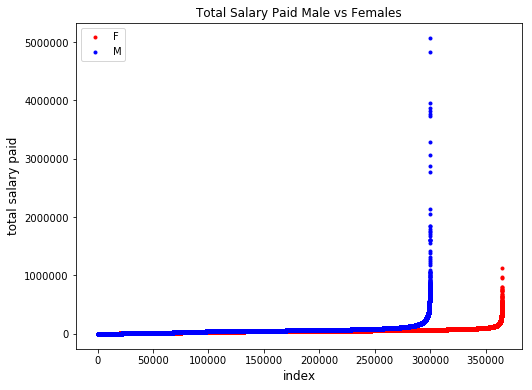

In [65]:
plt.figure(figsize=(8,6))
plt.scatter(range(f_data.shape[0]), np.sort(f_data["Total Salary Paid"].values),color="red",marker=".",label="F")
plt.scatter(range(m_data.shape[0]), np.sort(m_data["Total Salary Paid"].values),color="blue",marker=".",label="M")
plt.xlabel('index', fontsize=12)
plt.ylabel('total salary paid', fontsize=12)
plt.title("Total Salary Paid Male vs Females")
plt.legend(loc='upper left')
plt.show()

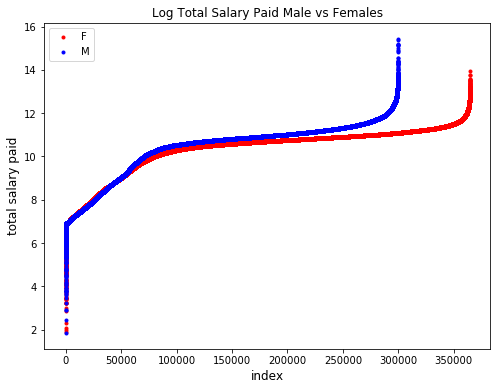

In [66]:
plt.figure(figsize=(8,6))
plt.scatter(range(f_data.shape[0]), np.sort(np.log(f_data["Total Salary Paid"].values)),color="red",marker=".",label="F")
plt.scatter(range(m_data.shape[0]), np.sort(np.log(m_data["Total Salary Paid"].values)),color="blue",marker=".",label="M")
plt.xlabel('index', fontsize=12)
plt.ylabel('total salary paid', fontsize=12)
plt.title("Log Total Salary Paid Male vs Females")
plt.legend(loc='upper left')
plt.show()

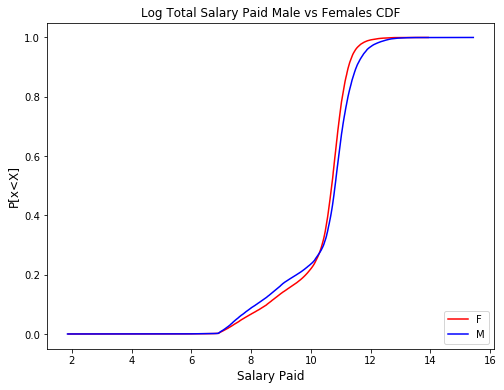

In [67]:
plt.figure(figsize=(8,6))
plt.plot(np.sort(np.log(f_data["Total Salary Paid"].values)), np.arange(len(f_data))/float(len(f_data)-1), color="red",label="F")
plt.plot(np.sort(np.log(m_data["Total Salary Paid"].values)), np.arange(len(m_data))/float(len(m_data)-1), color="blue",label="M")
plt.xlabel('Salary Paid', fontsize=12)
plt.ylabel('P[x<X]', fontsize=12)
plt.legend(loc='lower right')
plt.title("Log Total Salary Paid Male vs Females CDF")
plt.show()

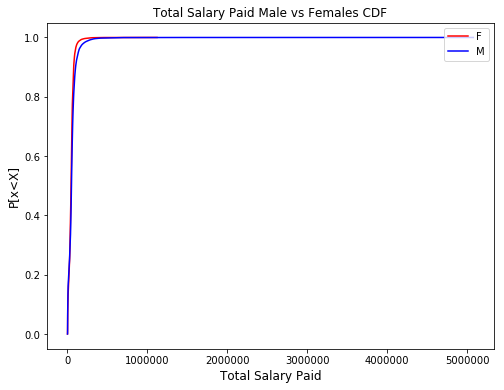

In [68]:
plt.figure(figsize=(8,6))
plt.plot(np.sort((f_data["Total Salary Paid"].values)), np.arange(len(f_data))/float(len(f_data)-1), color="red",label="F")
plt.plot(np.sort((m_data["Total Salary Paid"].values)), np.arange(len(m_data))/float(len(m_data)-1), color="blue",label="M")
plt.xlabel('Total Salary Paid', fontsize=12)
plt.ylabel('P[x<X]', fontsize=12)
plt.legend(loc='upper right')
plt.title("Total Salary Paid Male vs Females CDF")
plt.show()

In [69]:
X = np.arange(len(f_data))/float(len(f_data)-1)
Y = np.arange(len(m_data))/float(len(m_data)-1)
print(len(X))
print(len(Y))
y1s = np.ones(len(X)-len(Y))
Y = np.append(Y,y1s)
np.max(np.abs(X-Y))

364701
299628


0.17842884562654238

Conclusion: is a = 0.05 with threshold 0.41, since 0.178 < 0.41, we accept H0, male and females have same salary distribution

In [70]:
print(stats.ks_2samp(f_data["Total Salary Paid"].values,m_data["Total Salary Paid"].values))

Ks_2sampResult(statistic=0.11057406677300163, pvalue=0.0)


p value is very small, we reject H0 that two dis are same

In [71]:
stats.ks_2samp(f_data["Total Salary Paid"].values,stats.lognorm.rvs(.9,size=10000))

Ks_2sampResult(statistic=0.99996709633370895, pvalue=0.0)

p-value  is small, we reject H0 that same dis

In [72]:
def walds_test_2(data1, data2):
    w = 0
    x_mean = np.sum(data1)/float(len(data1))
    y_mean = np.sum(data2)/float(len(data2))
    print(x_mean)
    print(y_mean)

    x_var = np.var(data1)
    y_var = np.var(data2)
    print(x_var)
    print(y_var)
    w = (x_mean-y_mean)/(np.sqrt(x_var/len(data1)+y_var/len(data2)))
    return w

In [73]:
walds_test_2(f_data["Total Salary Paid"],m_data["Total Salary Paid"])

45384.1487249
55548.1486047
1067801480.56
3384851683.31


-85.220219920732106

Conclusion: reject H0 since 85 > Za/2

One sided, H0: FS - MS >= 0

Null: Females earn more than men

Alt: Females earn less than men

H1: FS - MS < 0

-85 < -Za, reject H0

### C) Mean Mobility: Male vs Females
Null: same mean mobility females/males 

Alt: diff mean mobility females/males 

Non parametric inference

(p1^ - p2^)/sqrt(var(F) - var(M))

(p1^ - p2^)/sqrt(var^(F)/n - var^(M)/m)

In [74]:
data["Name"].value_counts().head()

JONES JULIE A           32
OLSON SUSAN M           30
TAYLOR RICHARD D        25
MILLER MICHAEL J        24
KATES,KENNETH PHILIP    24
Name: Name, dtype: int64

Names - residence - position

JONES JULIE A Polk Pos1

              Polk Pos2
              
              ...  ...

#### FEMALES

In [75]:
f_data.columns

Index([u'Department', u'Agency/Institution', u'Name', u'Gender',
       u'Place of Residence', u'Position', u'Base Salary Payment Method',
       u'Base Salary Payment Amount', u'Total Salary Paid',
       u'Travel & Subsistence', u'Year', u'Employment Type',
       u'Hour's Worked Estimate', u'Hourly Wage Estimate',
       u'Employment Type 2'],
      dtype='object')

In [76]:
fm_data = f_data[["Name","Position","Place of Residence"]]
fm_data.head()

,Name,Position,Place of Residence
0,ABELS BEVERLY J,ADVANCED PERSONNEL MGMT,POLK
2,ADAMS CAROL L,ADVANCED PERSONNEL MGMT,MITCHELL
3,ADAMS JEANNIE R,ACCOUNTING TECHNICIAN 2,POLK
7,ALLEN ROSALIE R,EARLY OUT POSITION,CHEROKEE
8,ALLEN SANDRA L,INFO TECH SPECIALIST 2,POLK


In [77]:
fm_name_group = fm_data.groupby([fm_data["Name"],fm_data["Place of Residence"]])

In [78]:
fm_size_ser = fm_name_group.size()
fm_size_ser.head()

Name                 Place of Residence
A'HEARN, AMY K       JOHNSON                1
A'HEARN,AMY          LINN                   4
A'HEARN,AMY K        JOHNSON               10
A'HEARN,BRADY J'NEE  LINN                   3
AALBERS RONDA JOY    POLK                   6
dtype: int64

In [79]:
fm_size_ser[0]

1

In [80]:
len(fm_size_ser.head())

5

In [81]:
len(fm_data["Name"].unique())

97811

size won't work by itself, only tells us that ind had size jobs in year 20xy

In [82]:
name_position_map = {}

In [83]:
# name is the tuple (id), group is the df object for that tuple
for name, group in fm_name_group:    
    if name not in name_position_map:
        name_position_map[name] = set()   
    # gives list of position(s)
    # print(group["Position"].values) 
    name_position_map[name].update(group["Position"].values)    

In [84]:
f_total_mob = 0 # each change counts as 1 (5 diff jobs = 5 (or 4?) contrib)
f_total_ind_mob = 0 # change overall per person counts as 1 (5 diff jobs = 1 contrib)
X = [] # # of job changes for each female
X_ind = []
for key, value in name_position_map.items():
    if len(value) > 1:
        f_total_mob += len(value)-1
        f_total_ind_mob += 1
    X.append(len(value)-1)
    X_ind.append(len(value) > 1)
        
num_uni_fem = len(X)  
print(f_total_mob)
print(f_total_mob/float(num_uni_fem))
print(f_total_ind_mob)
print(f_total_ind_mob/float(num_uni_fem))

28310
0.267239344881
20982
0.198064851088


#### MALES

In [85]:
mm_data = m_data[["Name","Position","Place of Residence"]]
mm_data.head()

,Name,Position,Place of Residence
1,ABRAMS JERRY A,EARLY OUT POSITION,WAPELLO
4,ADAMS NED J,EARLY OUT POSITION,POLK
5,ADAMSON DAVID A,CONSTRUCTION/DESIGN ENGN,POLK
6,ALLEN DANIEL S,CUSTODIAL WORKER,POLK
9,ALLERHEILIGEN RICHARD D,EARLY OUT POSITION,NaN


In [86]:
mm_name_group = mm_data.groupby([mm_data["Name"],mm_data["Place of Residence"]])

In [87]:
m_name_position_map = {}

In [88]:
# name is the tuple (id), group is the df object for that tuple
for name, group in mm_name_group:    
    if name not in m_name_position_map:
        m_name_position_map[name] = set()   
    # gives list of position(s)
    # print(group["Position"].values) 
    m_name_position_map[name].update(group["Position"].values)    

In [89]:
m_total_mob = 0 # each change counts as 1 (5 diff jobs = 5 (or 4?) contrib)
m_total_ind_mob = 0 # change overall per person counts as 1 (5 diff jobs = 1 contrib)
Y = [] # # of job changes for each male
Y_ind = []
for key, value in m_name_position_map.items():
    if len(value) > 1:
        m_total_mob += len(value)-1
        m_total_ind_mob += 1
    Y.append(len(value)-1)
    Y_ind.append(len(value) > 1)
        
num_uni_male = len(Y)     
print(m_total_mob)
print(m_total_mob/float(num_uni_male))
print(m_total_ind_mob)
print(m_total_ind_mob/float(num_uni_male))

23038
0.274955840932
17300
0.206473480689


### Analysis
1) Parametric vs Non Parametric

2) Perm Test

Paramteric Bernoulli

In [90]:
Y_ind[:10]

[False, False, False, False, True, True, False, True, False, False]

In [91]:
np.array(Y_ind).astype(int)[:10]

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0])

In [92]:
Y_ind = np.array(Y_ind).astype(int)
X_ind = np.array(X_ind).astype(int)

In [93]:
walds_test(X_ind,Y_ind,part=1,dis="Bernoulli")

0.198064851088
0.206473480689
0.158835165851
0.163842182461


-4.5239069090259294

Non Parametric

In [94]:
t_abs = walds_test_2(X,Y)
print(t_abs)

0.267239344881
0.274955840932
0.37923683529
0.38379681263
-2.70123591487


Perm Test

In [95]:
# statistic is |X-Y|
U = X+Y
trials = 1000
p_value = 0
for trial in range(trials):
    np.random.shuffle(U)
    nX = U[:len(X)]
    nY = U[len(X):]
    nX_mean = np.mean(nX)
    nX_var = np.var(nX)
    nY_mean = np.mean(nY)
    nY_var = np.var(nY)
    top = nX_mean - nY_mean
    bottom = np.sqrt(nX_var/len(X)+nY_var/len(Y))
    T = np.abs(top/bottom)
    # print(T)
    # how many tests are larger than observed
    if T > np.abs(t_abs):
        p_value += 1
print(p_value/float(trials))

0.008


In [101]:
print(len(X))
print(len(Y))

105935
83788


In [110]:
# statistic is |Xind-Yind|
U = np.concatenate((X_ind,Y_ind))
trials = 1000
p_value = 0
for trial in range(trials):
    np.random.shuffle(U)
    nX = U[:len(X_ind)]
    nY = U[len(X_ind):]
    nX_mean = np.mean(nX)
    nX_var = np.var(nX)
    nY_mean = np.mean(nY)
    nY_var = np.var(nY)
    top = nX_mean - nY_mean
    bottom = np.sqrt(nX_var/len(X)+nY_var/len(Y))
    T = np.abs(top/bottom)
    # print(T)
    # how many tests are larger than observed
    if T > np.abs(t_abs):
        p_value += 1
print(p_value/float(trials))

0.009


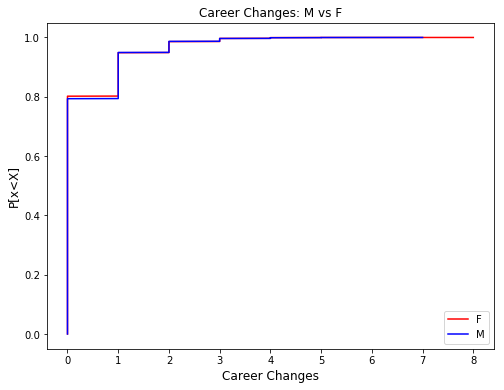

In [98]:
plt.figure(figsize=(8,6))
plt.plot(np.sort(X), np.arange(len(X))/float(len(X)-1), color="red",label="F")
plt.plot(np.sort(Y), np.arange(len(Y))/float(len(Y)-1), color="blue",label="M")
plt.xlabel('Career Changes', fontsize=12)
plt.ylabel('P[x<X]', fontsize=12)
plt.legend(loc='lower right')
plt.title("Career Changes: M vs F")
plt.show()

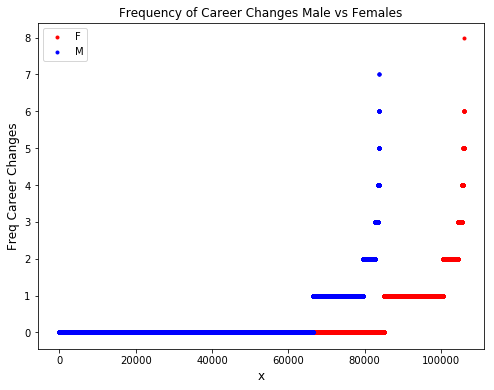

In [100]:
plt.figure(figsize=(8,6))
plt.scatter(range(len(X)), np.sort(X),color="red",marker=".",label="F")
plt.scatter(range(len(Y)), np.sort(Y),color="blue",marker=".",label="M")
plt.xlabel('x', fontsize=12)
plt.ylabel('Freq Career Changes', fontsize=12)
plt.title("Frequency of Career Changes Male vs Females")
plt.legend(loc='upper left')
plt.show()

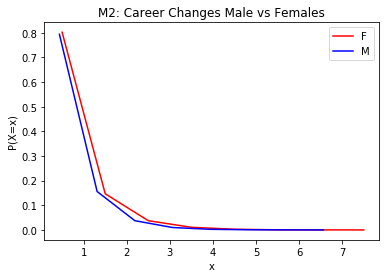

In [125]:
heights,bins = np.histogram(X,bins=8)
heights = heights/float(sum(heights))
binMids=bins[:-1]+np.diff(bins)/2
mheights,mbins = np.histogram(Y,bins=8)
mheights = mheights/float(sum(mheights))
mbinMids=mbins[:-1]+np.diff(mbins)/2
plt.plot(binMids,heights,color="red",label="F")
plt.plot(mbinMids,mheights,color="blue",label="M")

plt.xlabel('x')
plt.ylabel('P(X=x)')
plt.title("M2: Career Changes Male vs Females")
plt.legend(loc='upper right')
plt.show()

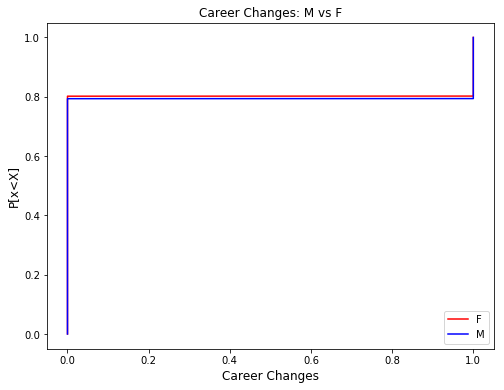

In [102]:
plt.figure(figsize=(8,6))
plt.plot(np.sort(X_ind), np.arange(len(X_ind))/float(len(X_ind)-1), color="red",label="F")
plt.plot(np.sort(Y_ind), np.arange(len(Y_ind))/float(len(Y_ind)-1), color="blue",label="M")
plt.xlabel('Career Changes', fontsize=12)
plt.ylabel('P[x<X]', fontsize=12)
plt.legend(loc='lower right')
plt.title("Career Changes: M vs F")
plt.show()

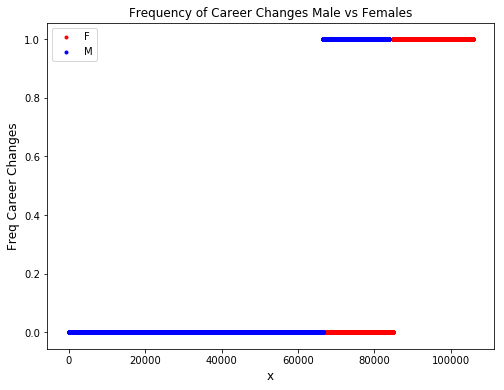

In [103]:
plt.figure(figsize=(8,6))
plt.scatter(range(len(X_ind)), np.sort(X_ind),color="red",marker=".",label="F")
plt.scatter(range(len(Y_ind)), np.sort(Y_ind),color="blue",marker=".",label="M")
plt.xlabel('x', fontsize=12)
plt.ylabel('Freq Career Changes', fontsize=12)
plt.title("Frequency of Career Changes Male vs Females")
plt.legend(loc='upper left')
plt.show()

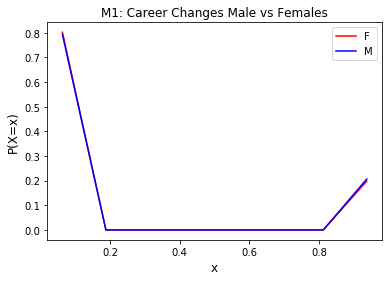

In [126]:
heights,bins = np.histogram(X_ind,bins=8)
heights = heights/float(sum(heights))
binMids=bins[:-1]+np.diff(bins)/2
mheights,mbins = np.histogram(Y_ind,bins=8)
mheights = mheights/float(sum(mheights))
mbinMids=mbins[:-1]+np.diff(mbins)/2
plt.plot(binMids,heights,color="red",label="F")
plt.plot(mbinMids,mheights,color="blue",label="M")

plt.xlabel('x', fontsize=12)
plt.ylabel('P(X=x)', fontsize=12)
plt.title("M1: Career Changes Male vs Females")
plt.legend(loc='upper right')
plt.figure(figsize=(8,6))
plt.show()

Conclusion: both wald's test give |w| > Za/2 = 1.962; different mobility rates

for a = 0.05 1 sided

Null: Females have more mobility Fm - Mm >= 0
Alt: Males have more mobility Fm - Mm < 0

-4.5 < -1.6449 for a = 0.05; two sided

-2.7 < -1.6449

Reject H0, conclude that males have more mobility

We reject H0 in both cases; they do not have the same mean mobility

We reject H0; fmo not > than mmo

For ~a = 0.003, one sided is when we accept H0 for non parametric

pvalue is very small, strong evidence against H0, therefore not same